# Day 14

# part 1

- robots move in straight lines from some position with some velocity
- x = 0 is left and y = 0 is at the top
- +x is right and +y is down
- robots don't bump into eachother
- when a robot hits a wall they wrap around to the otherside
- simulate for 100 seconds
- find the product of the number of robots in each quadrant (ignoring the centre lines)
- the puzzle grid is 101 wide by 103 tall

In [11]:
from copy import deepcopy
from dataclasses import dataclass
import logging

from matplotlib import pyplot as plt
from tqdm import tqdm

from advent_of_code_utils.advent_of_code_utils import (
    parse_from_file, ParseConfig as PC, Point2 as P, plot_grid, create_gif,
    embed_image, markdown
)

log = logging.getLogger('day 14')
logging.basicConfig(level=logging.INFO)

In [12]:
@dataclass
class Robot:
    p: P
    v: P

    def move(self, gridsize: P) -> None:
        """moves the robot one step"""
        self.p = P(
            (self.p.x + self.v.x) % gridsize.x,
            (self.p.y + self.v.y) % gridsize.y,
        )

def parse_robot(robot_str: str) -> Robot:
    """creates a robot from the puzzle input"""
    p_str, v_str = robot_str.split(' ')
    p = P(*(int(val) for val in p_str[2:].split(',')))
    v = P(*(int(val) for val in v_str[2:].split(',')))
    return Robot(p, v)

parser = PC('\n', parse_robot)
robots = parse_from_file('day_14.txt', parser)
gridsize = P(101, 103)

INFO:advent_of_code_utils.py:500 items loaded from "day_14.txt"


INFO:advent_of_code_utils.py:12 items loaded from "day_14_example.txt"


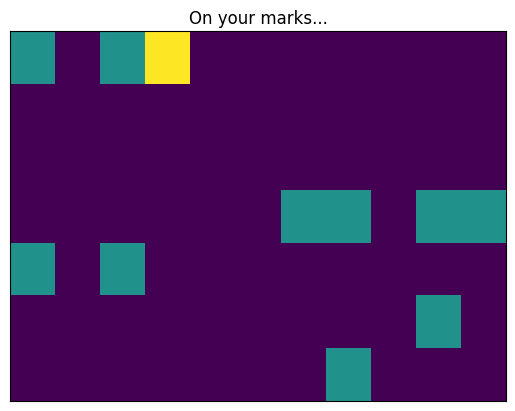

In [13]:
example = parse_from_file('day_14_example.txt', parser)

def plot_robots(robots: list[Robot], ax: plt.Axes, size=gridsize) -> None:
    """displays all the robots on a grid"""
    grid = [[0]*size.x for _ in range(size.y)]
    for robot in robots:
        grid[robot.p.y][robot.p.x] += 1
    plot_grid(grid, ax)

fig, ax = plt.subplots()
ax.set_title('On your marks...')
plot_robots(example, ax, P(11, 7))

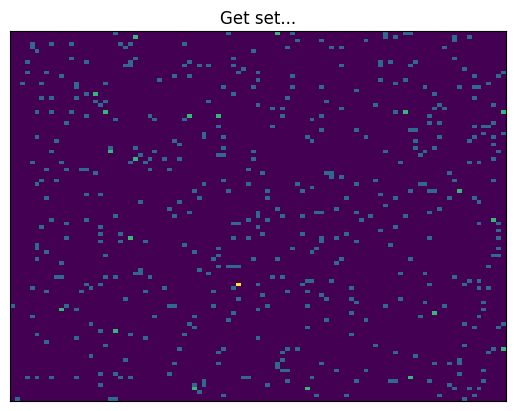

In [14]:
# cool that's the right way up - just wanted to be sure!
fig, ax = plt.subplots()
ax.set_title('Get set...')
plot_robots(robots, ax)

In [15]:
frames = [deepcopy(robots)]
for _ in tqdm(range(100)):
    for robot in robots:
        robot.move(gridsize)
    frames.append(deepcopy(robots))

100%|██████████| 100/100 [00:00<00:00, 110.98it/s]


INFO:advent_of_code_utils.py:Creating 101 frame images using "plot_robots()"
generating frames: 100%|██████████| 101/101 [00:03<00:00, 31.82it/s]
INFO:advent_of_code_utils.py:101 images saved to "img_temp"
INFO:advent_of_code_utils.py:Creating "day_14.gif" with frame duration 200ms
INFO:advent_of_code_utils.py:"day_14.gif" saved!
INFO:advent_of_code_utils.py:"img_temp" cleaned up
INFO:advent_of_code_utils.py:Embedding "day_14.gif"


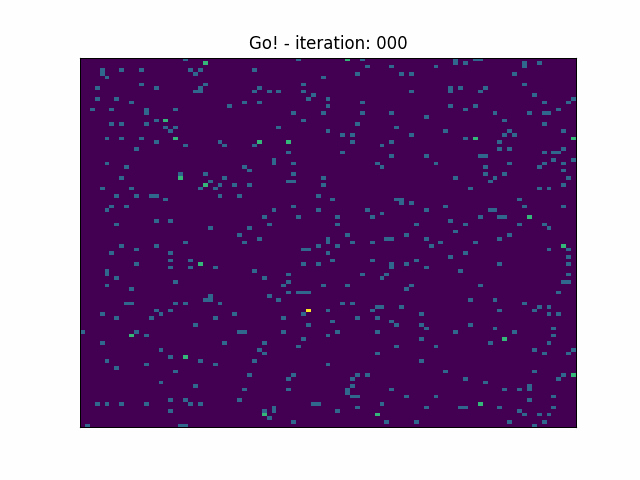

In [16]:
gifpath = create_gif(frames, plot_robots, 'day_14', append_iteration=True, title='Go!', frame_duration_ms=200)
embed_image(gifpath)

In [18]:
# ok now to find the solution
def get_safety_product(robots: list[Robot], gridsize) -> int:
    """returns the product of the safety value or whatever from each quad"""
    mid_x, mid_y = (gridsize.x - 1) // 2, (gridsize.y - 1) // 2
    bounds = [
        (P(0, 0), P(mid_x, mid_y)),
        (P(mid_x + 1, 0), P(gridsize.x, mid_y)),
        (P(0, mid_y + 1), P(mid_x, gridsize.y)),
        (P(mid_x + 1, mid_y + 1), P(gridsize.x, gridsize.y)),
    ]
    product = 1
    for a, b in bounds:
        log.info(f'checking in quadrant: {a} -> {b}')
        sub_total = 0
        for robot in robots:
            if robot.p.x < a.x:
                continue
            if robot.p.y < a.y:
                continue
            if robot.p.x >= b.x:
                continue
            if robot.p.y >= b.y:
                continue
            # else!
            sub_total += 1
        log.info(f'found {sub_total} robots in that quadrant')
        product *= sub_total
    log.info(f'Safety product thing: {product}')
    return product

safety = get_safety_product(robots, gridsize)
markdown(f'The safety factor thingy is: {safety}')

INFO:day 14:checking in quadrant: (0, 0) -> (50, 51)
INFO:day 14:found 116 robots in that quadrant
INFO:day 14:checking in quadrant: (51, 0) -> (101, 51)
INFO:day 14:found 124 robots in that quadrant
INFO:day 14:checking in quadrant: (0, 52) -> (50, 103)
INFO:day 14:found 126 robots in that quadrant
INFO:day 14:checking in quadrant: (51, 52) -> (101, 103)
INFO:day 14:found 127 robots in that quadrant
INFO:day 14:Safety product thing: 230172768


The safety factor thingy is: 230172768

## part 2

- The robots sometimes arrange themselves into a christmas tree
- find the first time that happens

In [19]:
robots = parse_from_file('day_14.txt', parser)
frames = [deepcopy(robots)]
for _ in tqdm(range(10000)):
    for robot in robots:
        robot.move(gridsize)
    frames.append(deepcopy(robots))

INFO:advent_of_code_utils.py:500 items loaded from "day_14.txt"
100%|██████████| 10000/10000 [01:29<00:00, 111.79it/s]


In [ ]:
# gifpath = create_gif(frames, plot_robots, 'day_14_part_2', append_iteration=True, title='Keep going...', frame_duration_ms=50)
# embed_image(gifpath)
# this hit an error 

soooo I'm sure there's a fancy maths way of solving this but how I ended up doing it was:
- my gif creator generates all the frames as images so I just ran it for 10000 iterations
- then while the function was taking 300 years to try and create the monster .gif file I had a look at the frames
- that's when I noticed a pattern
    - starting at frame 7, every 101 frames there was a consistent vertical cluster forming for 1 frame

    ![image](day_14_00007.png)
    - starting at frame 53, every 103 frames there was a consistent horizontal cluster forming for 1 frame.

    ![image](day_14_00053.png)
- hmm! that's the dimensions of the grid!
- after that I double checked and both 101 and 103 are prime - twin primes infact!
- So what I should have probably done is try and find the frame number that finally has the 2 clustering events happen at the same time.
- buuuut I actually lucked out and happened to find the convergent frame by just scrolling through them.
- and that frame is `8087`!

![image](day_14_08087.png)

INFO:advent_of_code_utils.py:Creating 81 frame images using "plot_robots()"
generating frames: 100%|██████████| 81/81 [00:04<00:00, 18.45it/s]
INFO:advent_of_code_utils.py:81 images saved to "img_temp"
INFO:advent_of_code_utils.py:Creating "day_14_part_2_v.gif" with frame duration 200ms
INFO:advent_of_code_utils.py:"day_14_part_2_v.gif" saved!
INFO:advent_of_code_utils.py:"img_temp" cleaned up
INFO:advent_of_code_utils.py:Embedding "day_14_part_2_v.gif"


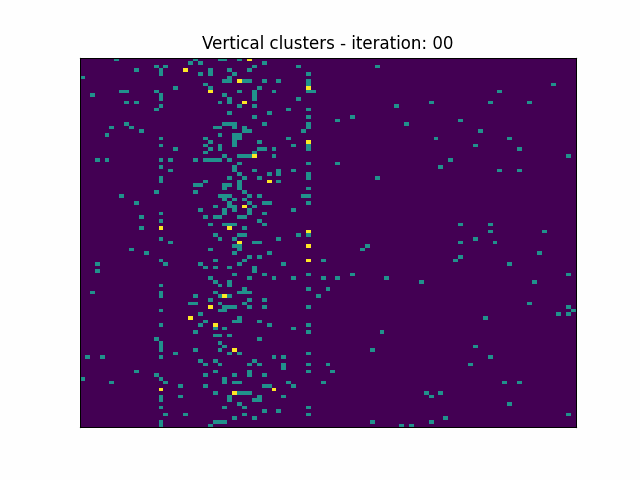

INFO:advent_of_code_utils.py:Creating 79 frame images using "plot_robots()"
generating frames: 100%|██████████| 79/79 [00:04<00:00, 18.69it/s]
INFO:advent_of_code_utils.py:79 images saved to "img_temp"
INFO:advent_of_code_utils.py:Creating "day_14_part_2_h.gif" with frame duration 200ms
INFO:advent_of_code_utils.py:"day_14_part_2_h.gif" saved!
INFO:advent_of_code_utils.py:"img_temp" cleaned up
INFO:advent_of_code_utils.py:Embedding "day_14_part_2_h.gif"


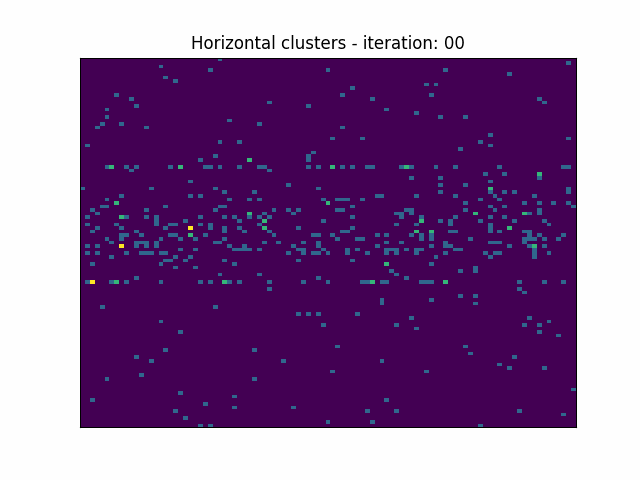

In [27]:
# while making a gif of all 10000 frames was probably a bad idea we can
# streamline which frames to show to just the convergent clusters
gifpath = create_gif(
    frames[7:8088:101], plot_robots, 'day_14_part_2_v',
    title='Vertical clusters', frame_duration_ms=200, append_iteration=True)
embed_image(gifpath)
gifpath = create_gif(
    frames[53:8088:103], plot_robots, 'day_14_part_2_h',
    title='Horizontal clusters', frame_duration_ms=200, append_iteration=True)
embed_image(gifpath)